# Comprehensive Model Comparison Analysis

This notebook compares all models tested in the Titanic survival prediction project:
- Logistic Regression (Austin)
- Support Vector Machines - Linear & RBF (SVM analysis)
- Decision Tree, Random Forest, Gradient Boosting, Bagging (Peter)
- Linear Discriminant Analysis (LDA) & Quadratic Discriminant Analysis (QDA) (Preethi)

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("Libraries imported successfully!")


Libraries imported successfully!


## 1. Load and Preprocess Data

In [45]:
# Load dataset
titanic = pd.read_csv("titanic_augmented.csv")
print(f"Dataset shape: {titanic.shape}")
print(f"\nSurvival distribution:\n{titanic['Survived'].value_counts()}")
print(f"\nSurvival rate: {titanic['Survived'].mean():.2%}")

Dataset shape: (891, 26)

Survival distribution:
Survived
0    549
1    342
Name: count, dtype: int64

Survival rate: 38.38%


In [46]:
# Common preprocessing for all models
df = titanic.copy()

# Fill missing values
df['Age'].fillna(df['Age'].median(), inplace=True)
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)

# Drop columns
df.drop(columns=['Cabin', 'cabin_room_number', 'title'], inplace=True)

# Encode Sex
df['Sex'] = df['Sex'].map({'male': 1, 'female': 0})

# Drop PassengerId, Name, Ticket
df.drop(columns=['PassengerId', 'Name', 'Ticket'], inplace=True)

# One-hot encode categorical variables
df_encoded = pd.get_dummies(df, columns=['Embarked'], drop_first=True)
df_encoded = pd.get_dummies(df_encoded, columns=['Pclass'], prefix='class', drop_first=True)
df_encoded = pd.get_dummies(df_encoded, columns=['title_group'], prefix='title', drop_first=True)
df_encoded = pd.get_dummies(df_encoded, columns=['cabin_deck'], prefix='cabin', drop_first=True)

print(f"Preprocessed data shape: {df_encoded.shape}")

Preprocessed data shape: (891, 32)


C:\Users\austi\AppData\Local\Temp\ipykernel_7768\1790503841.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age'].fillna(df['Age'].median(), inplace=True)
C:\Users\austi\AppData\Local\Temp\ipykernel_7768\1790503841.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exa

In [47]:
# Split data (same split for all models)
X = df_encoded.drop(columns=['Survived'])
y = df_encoded['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Number of features: {X.shape[1]}")

Training set: (668, 31)
Test set: (223, 31)
Number of features: 31


In [48]:
# Alternative preprocessing for tree-based models (label encoding)
df_tree = titanic.copy()

# Fill missing values
df_tree['Age'].fillna(df_tree['Age'].median(), inplace=True)
df_tree['Embarked'].fillna(df_tree['Embarked'].mode()[0], inplace=True)

# Drop columns
df_tree.drop(columns=['Cabin', 'cabin_room_number', 'title'], inplace=True)

# Binary encoding for Sex
df_tree['Sex'] = df_tree['Sex'].map({'male': 1, 'female': 0})

# Drop PassengerId, Name, Ticket
df_tree.drop(columns=['PassengerId', 'Name', 'Ticket'], inplace=True)

# Label encode categorical variables (better for trees)
le_embarked = LabelEncoder()
df_tree['Embarked'] = le_embarked.fit_transform(df_tree['Embarked'])

le_title = LabelEncoder()
df_tree['title_group'] = le_title.fit_transform(df_tree['title_group'])

le_cabin = LabelEncoder()
df_tree['cabin_deck'] = le_cabin.fit_transform(df_tree['cabin_deck'])

# Pclass is already numeric (1, 2, 3)

print(f"Tree-optimized data shape: {df_tree.shape}")

# Split tree data
X_tree = df_tree.drop(columns=['Survived'])
y_tree = df_tree['Survived']

X_train_tree, X_test_tree, y_train_tree, y_test_tree = train_test_split(
    X_tree, y_tree, test_size=0.25, random_state=42, stratify=y_tree
)

print(f"Tree training set: {X_train_tree.shape}")
print(f"Tree test set: {X_test_tree.shape}")

Tree-optimized data shape: (891, 20)
Tree training set: (668, 19)
Tree test set: (223, 19)


C:\Users\austi\AppData\Local\Temp\ipykernel_7768\1358050730.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_tree['Age'].fillna(df_tree['Age'].median(), inplace=True)
C:\Users\austi\AppData\Local\Temp\ipykernel_7768\1358050730.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy

### Alternative Preprocessing for Tree Models (Label Encoding)

Tree-based models can benefit from label encoding instead of one-hot encoding. Let's create an alternative dataset for trees.

## 2. Train All Models

In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.model_selection import ParameterGrid

# Define hyperparameter grids for GridSearchCV
param_grids = {
    'Logistic Regression': {
        'C': [0.1, 0.5, 1.0, 5.0, 10.0],
        'penalty': ['l2'],
        'solver': ['lbfgs', 'saga']
    },
    'SVM Linear': {
        'C': [0.1, 1.0, 10.0],
        'kernel': ['linear'],
        'gamma': ['scale']
    },
    'SVM RBF': {
        'C': [1.0, 5.0, 10.0],
        'kernel': ['rbf'],
        'gamma': ['scale', 'auto']
    },
    'Decision Tree': {
        'max_depth': [5, 10, 15, 20],
        'min_samples_split': [10, 20, 30],
        'min_samples_leaf': [5, 10, 15]
    },
    'Random Forest': {
        'n_estimators': [50, 100, 150],
        'max_depth': [10, 15, 20],
        'min_samples_split': [10, 20],
        'min_samples_leaf': [5, 10]
    },
    'Gradient Boosting': {
        'n_estimators': [50, 100, 150],
        'learning_rate': [0.05, 0.1, 0.15],
        'max_depth': [3, 5, 7],
        'min_samples_split': [10, 20]
    },
    'Bagging': {
        'n_estimators': [50, 100, 150],
        'max_samples': [0.8, 1.0],
        'max_features': [0.8, 1.0]
    },
    'LDA': {
        'solver': ['svd', 'lsqr'],  # Only stable solvers (eigen removed - numerically unstable)
        'shrinkage': [None]  # SVD doesn't support shrinkage; using None for compatibility
    },
    'QDA': {
        'reg_param': [0.0, 0.1]  # Only stable regularization values (reduced from [0.0, 0.5, 1.0])
    }
}

# Initialize base models (will be used in GridSearchCV)
base_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'SVM Linear': SVC(probability=True, random_state=42),
    'SVM RBF': SVC(probability=True, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Bagging': BaggingClassifier(estimator=DecisionTreeClassifier(random_state=42), random_state=42, n_jobs=-1),
    'LDA': LinearDiscriminantAnalysis(),
    'QDA': QuadraticDiscriminantAnalysis()
}

print(f"Total models to tune: {len(base_models)}")
print("Hyperparameter grids defined for GridSearchCV")
print("Note: LDA uses only stable solvers (svd, lsqr); eigen solver removed")
print("Note: QDA uses only stable regularization parameters")
print("Cross-validation will use 5-fold for hyperparameter tuning")


Total models to tune: 9
Hyperparameter grids defined for GridSearchCV
Note: LDA uses only stable solvers (svd, lsqr); eigen solver removed
Note: QDA uses only stable regularization parameters
Cross-validation will use 5-fold for hyperparameter tuning


In [50]:
# Train all models with GridSearchCV for hyperparameter tuning
results = []
trained_models = {}

def count_param_combinations(param_grid):
    """Count total parameter combinations for both dict and list-based grids"""
    if isinstance(param_grid, list):
        # For list of dicts (like LDA), sum combinations from each dict
        total = 0
        for grid_dict in param_grid:
            combo = 1
            for values in grid_dict.values():
                combo *= len(values)
            total += combo
        return total
    else:
        # For single dict, multiply all value lengths
        combo = 1
        for values in param_grid.values():
            combo *= len(values)
        return combo

for name, base_model in base_models.items():
    print(f"\n{'='*60}")
    print(f"Training {name} with GridSearchCV...")
    print(f"{'='*60}")
    
    # Determine which data to use
    if name in ['Decision Tree', 'Random Forest', 'Gradient Boosting', 'Bagging']:
        X_train_data = X_train_tree
        X_test_data = X_test_tree
        y_train_data = y_train_tree
        y_test_data = y_test_tree
        use_tree_data = True
    else:
        X_train_data = X_train_scaled
        X_test_data = X_test_scaled
        y_train_data = y_train
        y_test_data = y_test
        use_tree_data = False
    
    # Count parameter combinations
    n_combos = count_param_combinations(param_grids[name])
    
    # Perform GridSearchCV with 5-fold cross-validation
    grid_search = GridSearchCV(
        estimator=base_model,
        param_grid=param_grids[name],
        cv=5,
        scoring='f1_weighted',
        n_jobs=-1,
        verbose=0
    )
    
    print(f"Searching {n_combos} parameter combinations with 5-fold CV...")
    grid_search.fit(X_train_data, y_train_data)
    
    # Get best model
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_cv_score = grid_search.best_score_
    
    print(f"✓ Best CV F1-Score: {best_cv_score:.4f}")
    print(f"✓ Best parameters: {best_params}")
    
    # Make predictions with best model
    y_train_pred = best_model.predict(X_train_data)
    y_test_pred = best_model.predict(X_test_data)
    y_test_proba = best_model.predict_proba(X_test_data)[:, 1]
    
    # Calculate metrics on test set
    train_acc = accuracy_score(y_train_data, y_train_pred)
    test_acc = accuracy_score(y_test_data, y_test_pred)
    precision = precision_score(y_test_data, y_test_pred)
    recall = recall_score(y_test_data, y_test_pred)
    f1 = f1_score(y_test_data, y_test_pred)
    roc_auc = roc_auc_score(y_test_data, y_test_proba)
    
    # Perform cross-validation on training data for comparison metrics
    cv_scores = cross_validate(
        best_model, X_train_data, y_train_data,
        cv=5,
        scoring={'accuracy': 'accuracy', 'f1_weighted': 'f1_weighted', 'roc_auc': 'roc_auc'},
        return_train_score=False
    )
    
    cv_acc_mean = cv_scores['test_accuracy'].mean()
    cv_acc_std = cv_scores['test_accuracy'].std()
    cv_f1_mean = cv_scores['test_f1_weighted'].mean()
    cv_f1_std = cv_scores['test_f1_weighted'].std()
    cv_auc_mean = cv_scores['test_roc_auc'].mean()
    cv_auc_std = cv_scores['test_roc_auc'].std()
    
    results.append({
        'Model': name,
        'Best_Params': str(best_params),
        'GridSearch_CV_Score': best_cv_score,
        'Train_Accuracy': train_acc,
        'Test_Accuracy': test_acc,
        'CV_Accuracy_Mean': cv_acc_mean,
        'CV_Accuracy_Std': cv_acc_std,
        'Precision': precision,
        'Recall': recall,
        'F1_Score': f1,
        'CV_F1_Mean': cv_f1_mean,
        'CV_F1_Std': cv_f1_std,
        'ROC_AUC': roc_auc,
        'CV_ROC_AUC_Mean': cv_auc_mean,
        'CV_ROC_AUC_Std': cv_auc_std,
        'Overfit_Gap': train_acc - test_acc,
        'y_test_pred': y_test_pred,
        'y_test_proba': y_test_proba,
        'best_model': best_model
    })
    
    trained_models[name] = best_model
    
    print(f"Test Accuracy: {test_acc:.4f} | F1: {f1:.4f} | ROC-AUC: {roc_auc:.4f}")
    print(f"CV Accuracy: {cv_acc_mean:.4f} ± {cv_acc_std:.4f}")

# Create results DataFrame
results_df = pd.DataFrame(results)
print("\n" + "="*80)
print("All models trained and tuned with GridSearchCV!")
print("="*80)



Training Logistic Regression with GridSearchCV...
Searching 10 parameter combinations with 5-fold CV...
✓ Best CV F1-Score: 0.8387
✓ Best parameters: {'C': 0.5, 'penalty': 'l2', 'solver': 'saga'}
Test Accuracy: 0.8206 | F1: 0.7674 | ROC-AUC: 0.8586
CV Accuracy: 0.8399 ± 0.0353

Training SVM Linear with GridSearchCV...
Searching 3 parameter combinations with 5-fold CV...
✓ Best CV F1-Score: 0.8344
✓ Best parameters: {'C': 1.0, 'gamma': 'scale', 'kernel': 'linear'}
Test Accuracy: 0.8161 | F1: 0.7602 | ROC-AUC: 0.8401
CV Accuracy: 0.8353 ± 0.0323

Training SVM RBF with GridSearchCV...
Searching 6 parameter combinations with 5-fold CV...
✓ Best CV F1-Score: 0.8280
✓ Best parameters: {'C': 10.0, 'gamma': 'scale', 'kernel': 'rbf'}
Test Accuracy: 0.7578 | F1: 0.6707 | ROC-AUC: 0.8307
CV Accuracy: 0.8293 ± 0.0385

Training Decision Tree with GridSearchCV...
Searching 36 parameter combinations with 5-fold CV...
✓ Best CV F1-Score: 0.7924
✓ Best parameters: {'max_depth': 10, 'min_samples_leaf':

## 3. Model Performance Comparison

In [51]:
# Display comprehensive results table with cross-validation metrics
display_df = results_df[['Model', 'Train_Accuracy', 'Test_Accuracy', 
                         'CV_Accuracy_Mean', 'CV_Accuracy_Std',
                         'Precision', 'Recall', 'F1_Score', 
                         'CV_F1_Mean', 'CV_F1_Std', 'ROC_AUC', 'CV_ROC_AUC_Mean', 'CV_ROC_AUC_Std', 'Overfit_Gap']].copy()

display_df = display_df.sort_values('CV_Accuracy_Mean', ascending=False).reset_index(drop=True)

print("\n" + "="*130)
print("MODEL PERFORMANCE COMPARISON WITH CROSS-VALIDATION (Sorted by CV Accuracy Mean)")
print("="*130)
print(display_df.to_string(index=False))
print("="*130)

# Identify best model
best_model_name = display_df.iloc[0]['Model']
best_acc = display_df.iloc[0]['Test_Accuracy']
best_cv_acc = display_df.iloc[0]['CV_Accuracy_Mean']
print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   Test Accuracy: {best_acc:.4f}")
print(f"   Cross-Validation Accuracy: {best_cv_acc:.4f} (5-fold mean)")


MODEL PERFORMANCE COMPARISON WITH CROSS-VALIDATION (Sorted by CV Accuracy Mean)
              Model  Train_Accuracy  Test_Accuracy  CV_Accuracy_Mean  CV_Accuracy_Std  Precision   Recall  F1_Score  CV_F1_Mean  CV_F1_Std  ROC_AUC  CV_ROC_AUC_Mean  CV_ROC_AUC_Std  Overfit_Gap
  Gradient Boosting        1.000000       0.798206          0.847290         0.013185   0.746988 0.720930  0.733728    0.845050   0.012840 0.836106         0.883626        0.022390     0.201794
Logistic Regression        0.842814       0.820628          0.839861         0.035339   0.767442 0.767442  0.767442    0.838732   0.035235 0.858598         0.860890        0.038605     0.022187
      Random Forest        0.910180       0.798206          0.836786         0.024077   0.730337 0.755814  0.742857    0.834841   0.023443 0.862842         0.876988        0.032024     0.111973
         SVM Linear        0.839820       0.816143          0.835350         0.032259   0.764706 0.755814  0.760234    0.834433   0.032484 0.84

## 4. Visualization 1: Overall Performance Comparison

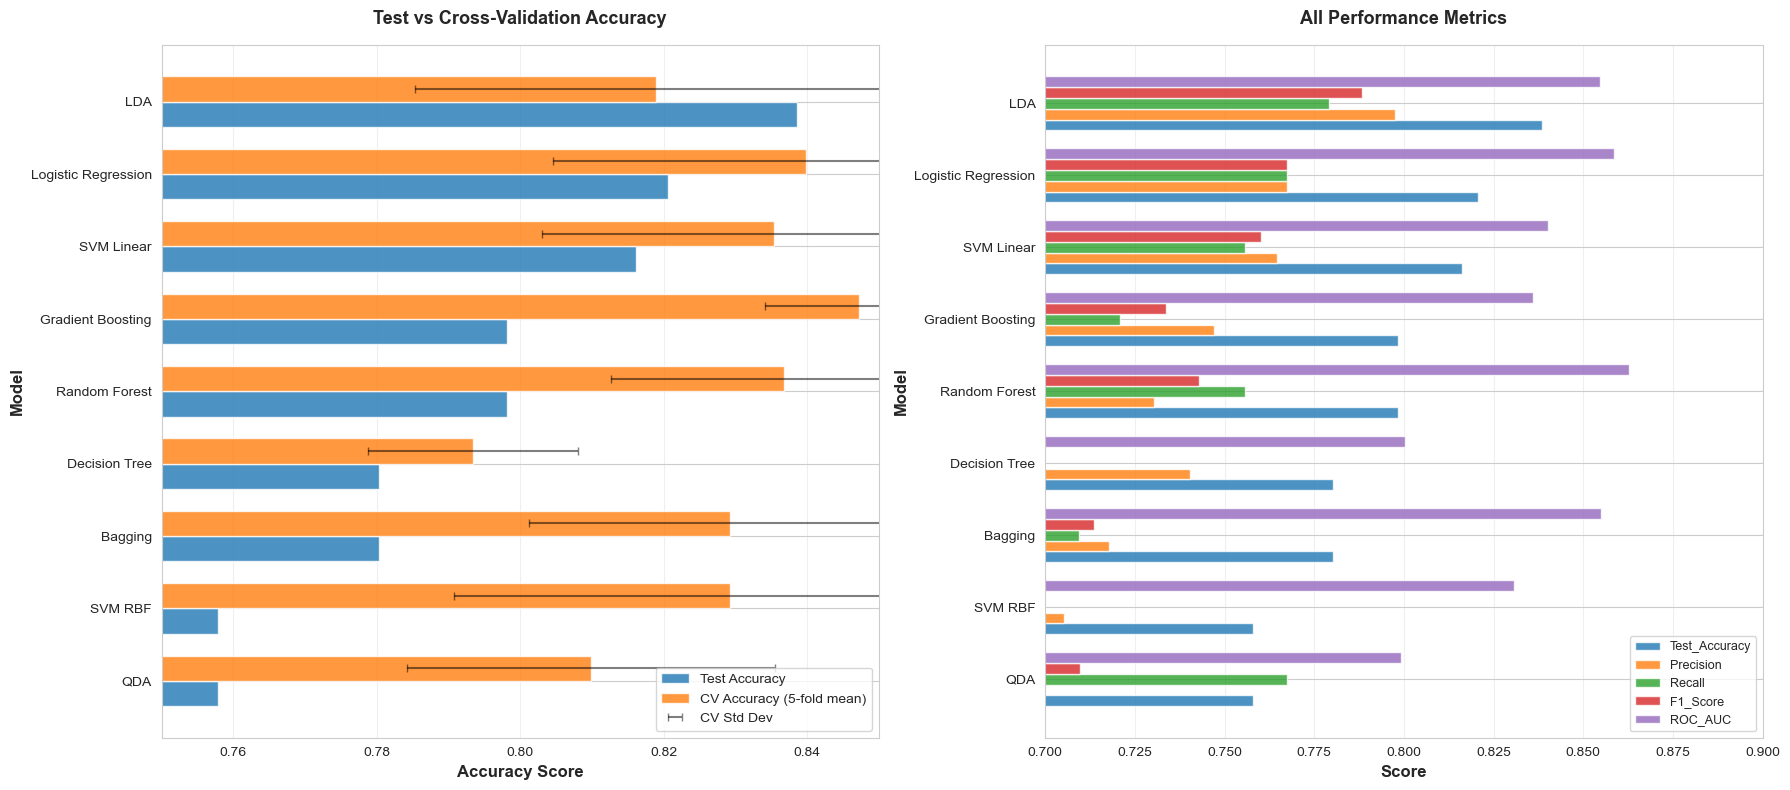

Visualization 1: Performance Comparison with Cross-Validation - Complete


In [52]:
# Create comprehensive bar chart comparison with cross-validation
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Sort by test accuracy
plot_df = display_df.sort_values('Test_Accuracy', ascending=True)

# Left plot: Test Accuracy vs Cross-Validation Accuracy
ax1 = axes[0]
x = np.arange(len(plot_df))
width = 0.35

bars1 = ax1.barh(x - width/2, plot_df['Test_Accuracy'], width, 
                  label='Test Accuracy', color='#1f77b4', alpha=0.8)
bars2 = ax1.barh(x + width/2, plot_df['CV_Accuracy_Mean'], width,
                  label='CV Accuracy (5-fold mean)', color='#ff7f0e', alpha=0.8)

# Add error bars for CV std
ax1.errorbar(plot_df['CV_Accuracy_Mean'], x + width/2, 
             xerr=plot_df['CV_Accuracy_Std'], fmt='none', 
             color='black', alpha=0.5, capsize=3, label='CV Std Dev')

ax1.set_yticks(x)
ax1.set_yticklabels(plot_df['Model'])
ax1.set_xlabel('Accuracy Score', fontsize=12, fontweight='bold')
ax1.set_ylabel('Model', fontsize=12, fontweight='bold')
ax1.set_title('Test vs Cross-Validation Accuracy', fontsize=13, fontweight='bold', pad=15)
ax1.legend(loc='lower right', fontsize=10)
ax1.set_xlim([0.75, 0.85])
ax1.grid(axis='x', alpha=0.3)

# Right plot: All performance metrics
ax2 = axes[1]
metrics = ['Test_Accuracy', 'Precision', 'Recall', 'F1_Score', 'ROC_AUC']
x = np.arange(len(plot_df))
width = 0.15

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

for i, metric in enumerate(metrics):
    offset = (i - 2) * width
    ax2.barh(x + offset, plot_df[metric], width, label=metric, color=colors[i], alpha=0.8)

ax2.set_yticks(x)
ax2.set_yticklabels(plot_df['Model'])
ax2.set_xlabel('Score', fontsize=12, fontweight='bold')
ax2.set_ylabel('Model', fontsize=12, fontweight='bold')
ax2.set_title('All Performance Metrics', fontsize=13, fontweight='bold', pad=15)
ax2.legend(loc='lower right', fontsize=9)
ax2.set_xlim([0.7, 0.9])
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("Visualization 1: Performance Comparison with Cross-Validation - Complete")


## 5. Visualization 2: Train vs Test Accuracy (Overfitting Analysis)

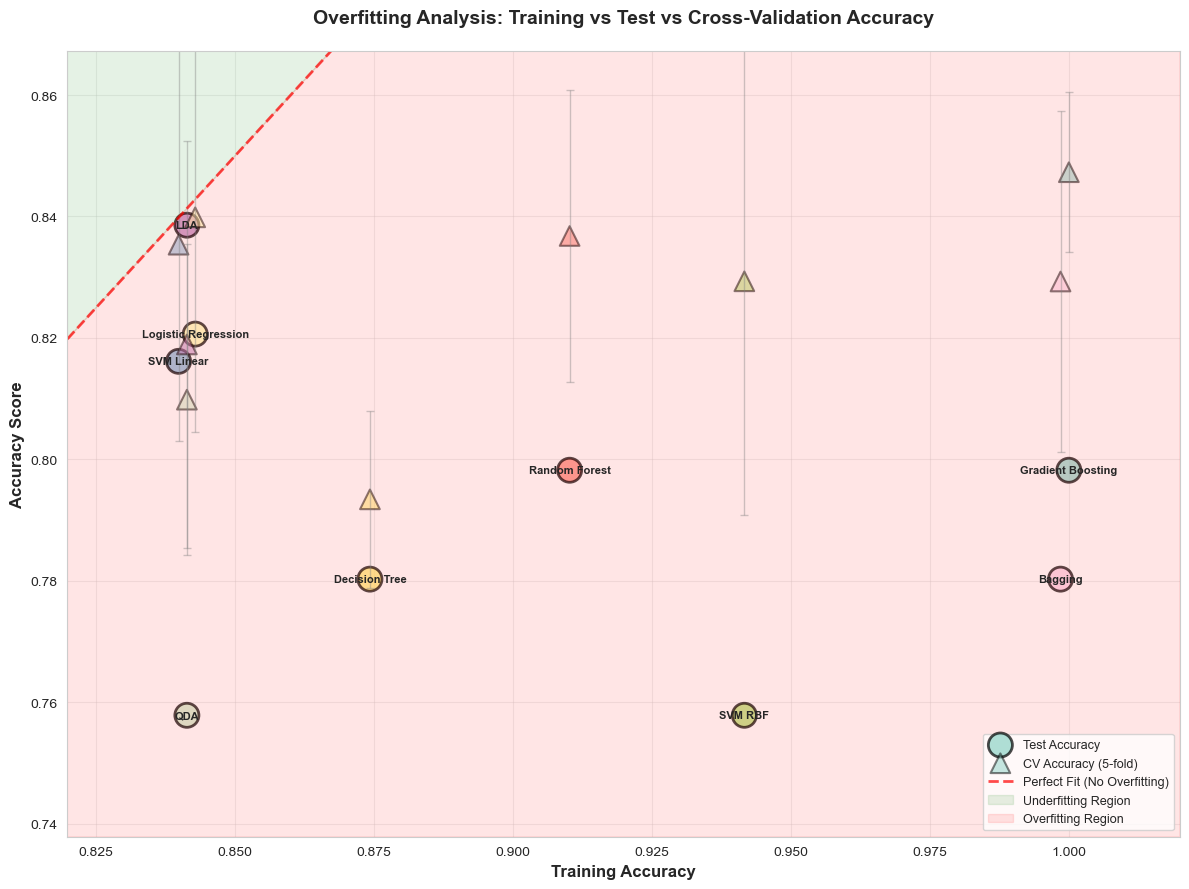

Visualization 2: Overfitting Analysis with Cross-Validation - Complete


In [53]:
# Overfitting analysis scatter plot with cross-validation insights
fig, ax = plt.subplots(figsize=(12, 9))

# Create scatter plot
colors_map = plt.cm.Set3(np.linspace(0, 1, len(display_df)))
scatter = ax.scatter(display_df['Train_Accuracy'], display_df['Test_Accuracy'], 
                     s=300, c=colors_map, alpha=0.7, edgecolors='black', linewidth=2,
                     label='Test Accuracy')

# Plot CV Accuracy as well (slightly offset for visibility)
scatter2 = ax.scatter(display_df['Train_Accuracy'], display_df['CV_Accuracy_Mean'], 
                      s=200, c=colors_map, alpha=0.5, marker='^', edgecolors='black', linewidth=1.5,
                      label='CV Accuracy (5-fold)')

# Add error bars for CV std
ax.errorbar(display_df['Train_Accuracy'], display_df['CV_Accuracy_Mean'],
            yerr=display_df['CV_Accuracy_Std'], fmt='none', color='gray', 
            alpha=0.4, capsize=3, linewidth=1)

# Set dynamic axis limits based on actual data with padding
x_min = display_df['Train_Accuracy'].min() - 0.02
x_max = display_df['Train_Accuracy'].max() + 0.02
y_min = min(display_df['Test_Accuracy'].min(), display_df['CV_Accuracy_Mean'].min()) - 0.02
y_max = max(display_df['Test_Accuracy'].max(), display_df['CV_Accuracy_Mean'].max()) + 0.02

# Add model labels
for idx, row in display_df.iterrows():
    ax.annotate(row['Model'], 
                (row['Train_Accuracy'], row['Test_Accuracy']),
                fontsize=8, ha='center', va='center', fontweight='bold')

# Add perfect fit line (diagonal from bottom-left to top-right)
diag_min = max(x_min, y_min)
diag_max = min(x_max, y_max)
ax.plot([diag_min, diag_max], [diag_min, diag_max], 'r--', linewidth=2, label='Perfect Fit (No Overfitting)', alpha=0.7)

# Add underfitting/overfitting regions
ax.fill_between([x_min, x_max], [x_min, x_max], [y_max, y_max], alpha=0.1, color='green', label='Underfitting Region')
ax.fill_between([x_min, x_max], [x_min, x_max], [y_min, y_min], alpha=0.1, color='red', label='Overfitting Region')

ax.set_xlabel('Training Accuracy', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy Score', fontsize=12, fontweight='bold')
ax.set_title('Overfitting Analysis: Training vs Test vs Cross-Validation Accuracy', fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='lower right', fontsize=9)
ax.grid(alpha=0.3)

# Set dynamic axis limits based on actual data with padding
x_min = display_df['Train_Accuracy'].min() - 0.02
x_max = display_df['Train_Accuracy'].max() + 0.02
y_min = min(display_df['Test_Accuracy'].min(), display_df['CV_Accuracy_Mean'].min()) - 0.02
y_max = max(display_df['Test_Accuracy'].max(), display_df['CV_Accuracy_Mean'].max()) + 0.02

ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])

plt.tight_layout()
plt.show()

print("Visualization 2: Overfitting Analysis with Cross-Validation - Complete")


## 6. Visualization 3: Performance Heatmap

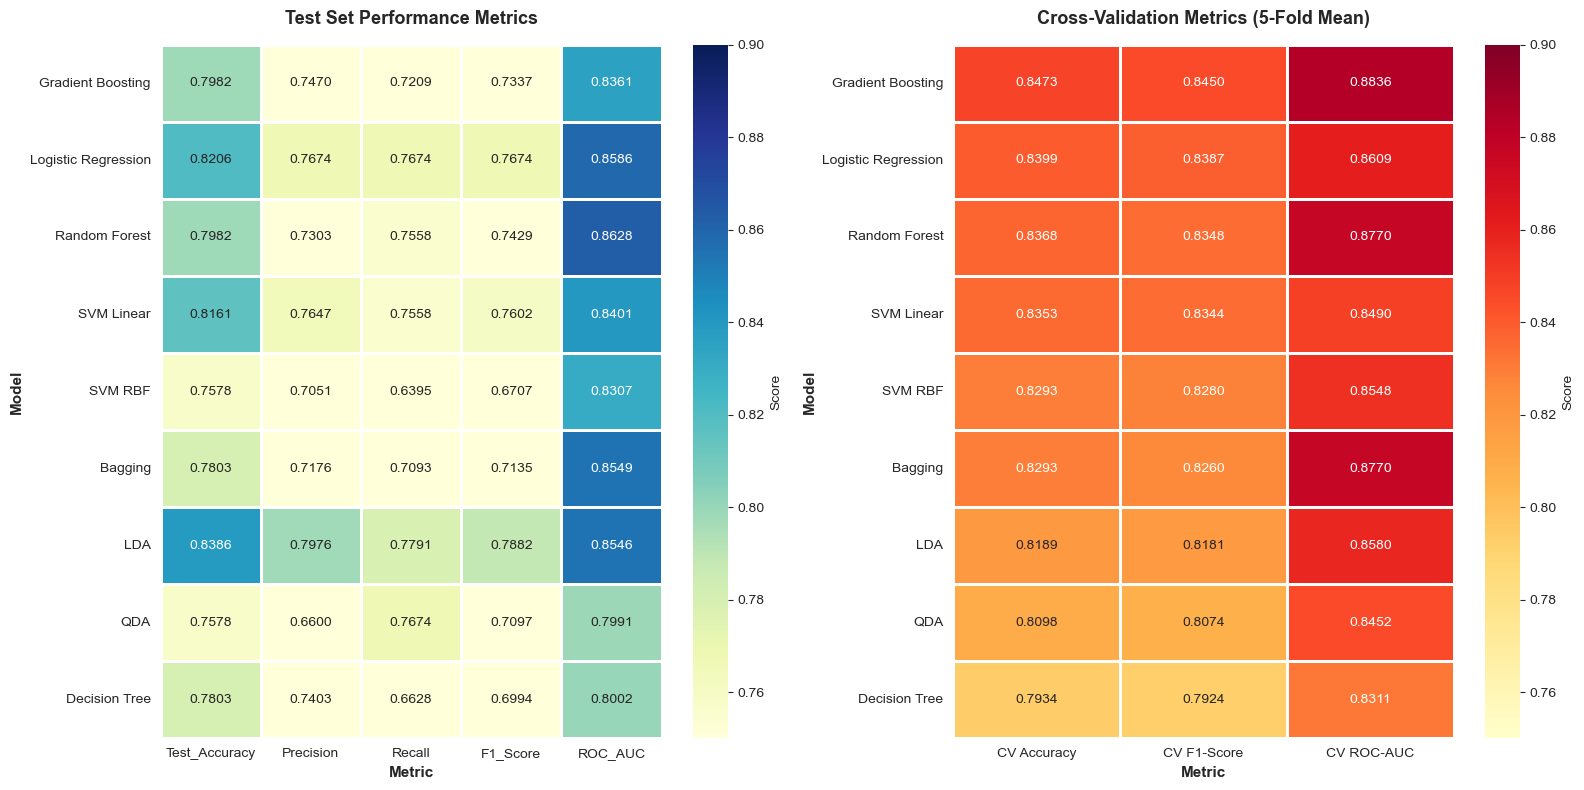

Visualization 3: Performance Heatmap (Test Set vs Cross-Validation) - Complete


In [54]:
# Create heatmap of all metrics including cross-validation scores
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Left heatmap: Test set metrics
heatmap_data1 = display_df[['Model', 'Test_Accuracy', 'Precision', 'Recall', 'F1_Score', 'ROC_AUC']].set_index('Model')
sns.heatmap(heatmap_data1, annot=True, fmt='.4f', cmap='YlGnBu', cbar_kws={'label': 'Score'}, 
            linewidths=1, linecolor='white', ax=axes[0], vmin=0.75, vmax=0.90)
axes[0].set_title('Test Set Performance Metrics', fontsize=13, fontweight='bold', pad=15)
axes[0].set_xlabel('Metric', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Model', fontsize=11, fontweight='bold')

# Right heatmap: Cross-validation metrics
heatmap_data2 = display_df[['Model', 'CV_Accuracy_Mean', 'CV_F1_Mean', 'CV_ROC_AUC_Mean']].set_index('Model')
heatmap_data2.columns = ['CV Accuracy', 'CV F1-Score', 'CV ROC-AUC']
sns.heatmap(heatmap_data2, annot=True, fmt='.4f', cmap='YlOrRd', cbar_kws={'label': 'Score'}, 
            linewidths=1, linecolor='white', ax=axes[1], vmin=0.75, vmax=0.90)
axes[1].set_title('Cross-Validation Metrics (5-Fold Mean)', fontsize=13, fontweight='bold', pad=15)
axes[1].set_xlabel('Metric', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Model', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print("Visualization 3: Performance Heatmap (Test Set vs Cross-Validation) - Complete")


## 6a. Visualization 3a: Cross-Validation Fold Analysis

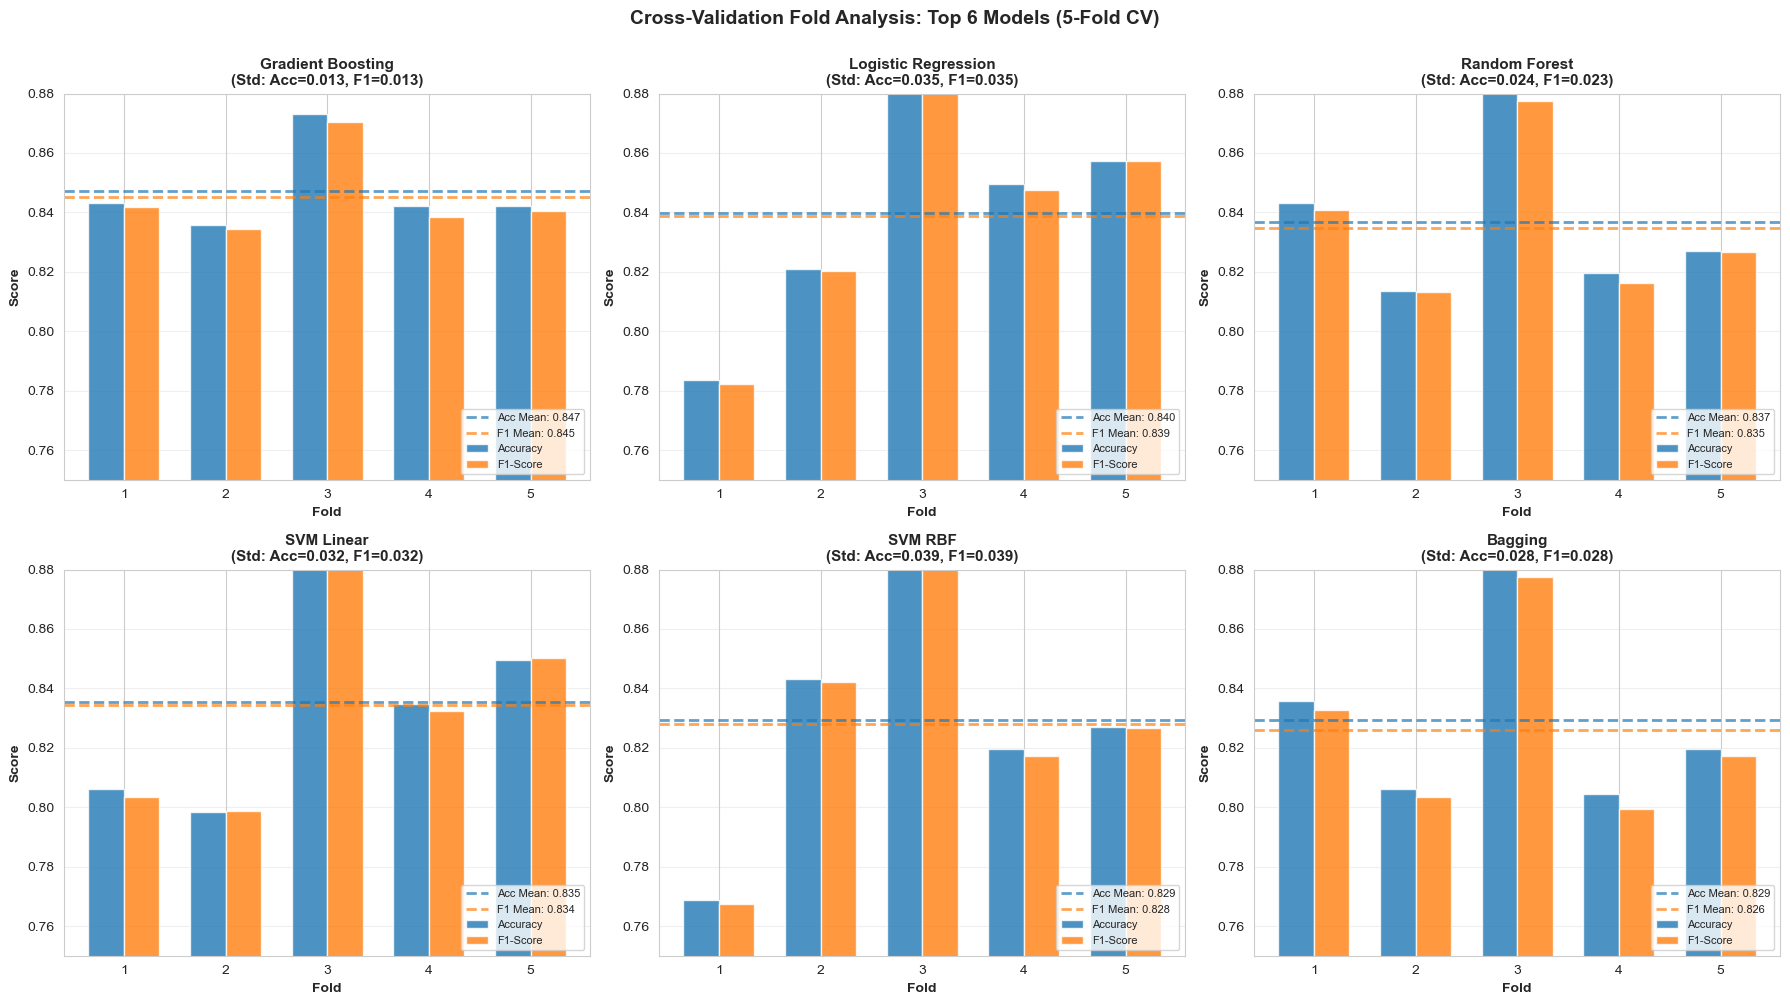

Visualization 3a: Cross-Validation Fold Analysis - Complete


In [55]:
# Cross-validation fold analysis for top 6 models
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

top_6_models = display_df.head(6)['Model'].tolist()

for idx, model_name in enumerate(top_6_models):
    ax = axes[idx]
    
    # Get the model data
    model_data = results_df[results_df['Model'] == model_name].iloc[0]
    
    # Determine which data to use
    if model_name in ['Decision Tree', 'Random Forest', 'Gradient Boosting', 'Bagging']:
        X_data = X_train_tree
        y_data = y_train_tree
    else:
        X_data = X_train_scaled
        y_data = y_train
    
    # Perform cross-validation with 5 folds
    best_model = model_data['best_model']
    cv_scores_acc = cross_val_score(best_model, X_data, y_data, cv=5, scoring='accuracy')
    cv_scores_f1 = cross_val_score(best_model, X_data, y_data, cv=5, scoring='f1_weighted')
    
    # Create bar chart
    folds = np.arange(1, 6)
    width = 0.35
    
    ax.bar(folds - width/2, cv_scores_acc, width, label='Accuracy', color='#1f77b4', alpha=0.8)
    ax.bar(folds + width/2, cv_scores_f1, width, label='F1-Score', color='#ff7f0e', alpha=0.8)
    
    # Add mean lines
    ax.axhline(y=cv_scores_acc.mean(), color='#1f77b4', linestyle='--', linewidth=2, alpha=0.7, label=f'Acc Mean: {cv_scores_acc.mean():.3f}')
    ax.axhline(y=cv_scores_f1.mean(), color='#ff7f0e', linestyle='--', linewidth=2, alpha=0.7, label=f'F1 Mean: {cv_scores_f1.mean():.3f}')
    
    ax.set_xlabel('Fold', fontsize=10, fontweight='bold')
    ax.set_ylabel('Score', fontsize=10, fontweight='bold')
    ax.set_title(f'{model_name}\n(Std: Acc={cv_scores_acc.std():.3f}, F1={cv_scores_f1.std():.3f})', 
                 fontsize=11, fontweight='bold')
    ax.set_xticks(folds)
    ax.set_ylim([0.75, 0.88])
    ax.legend(fontsize=8, loc='lower right')
    ax.grid(axis='y', alpha=0.3)

plt.suptitle('Cross-Validation Fold Analysis: Top 6 Models (5-Fold CV)', 
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("Visualization 3a: Cross-Validation Fold Analysis - Complete")


## 7. Visualization 4: ROC Curves Comparison

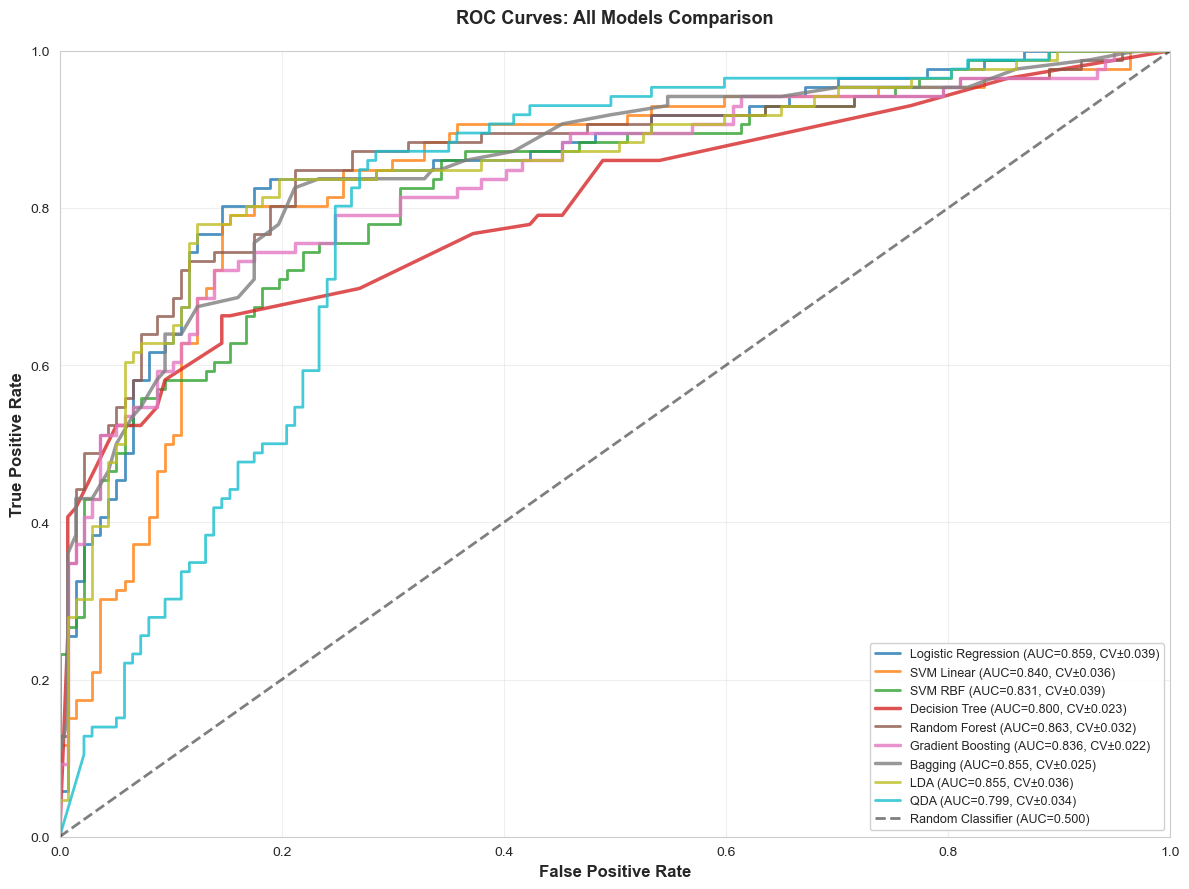

Visualization 4: ROC Curves Comparison - Complete


In [64]:
# Plot ROC curves for all models with cross-validation reliability indicators
fig, ax = plt.subplots(figsize=(12, 9))

colors = plt.cm.tab10(np.linspace(0, 1, len(results_df)))

for idx, row in results_df.iterrows():
    # Use appropriate y_test based on model type
    if row['Model'] in ['Decision Tree', 'Random Forest', 'Gradient Boosting', 'Bagging']:
        fpr, tpr, _ = roc_curve(y_test_tree, row['y_test_proba'])
    else:
        fpr, tpr, _ = roc_curve(y_test, row['y_test_proba'])
    
    # Line width based on CV consistency (lower std = thicker line)
    cv_std = row['CV_ROC_AUC_Std']
    line_width = 3.0 if cv_std < 0.02 else 2.5 if cv_std < 0.03 else 2.0
    
    ax.plot(fpr, tpr, label=f"{row['Model']} (AUC={row['ROC_AUC']:.3f}, CV±{cv_std:.3f})", 
            linewidth=line_width, color=colors[idx], alpha=0.8)

# Add diagonal line (random classifier)
ax.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier (AUC=0.500)', alpha=0.5)

ax.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax.set_title('ROC Curves: All Models Comparison', 
             fontsize=13, fontweight='bold', pad=20)
ax.legend(loc='lower right', fontsize=9, framealpha=0.9)
ax.grid(alpha=0.3)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

plt.tight_layout()
plt.show()

print("Visualization 4: ROC Curves Comparison - Complete")


## 8. Visualization 5: Precision-Recall Trade-off

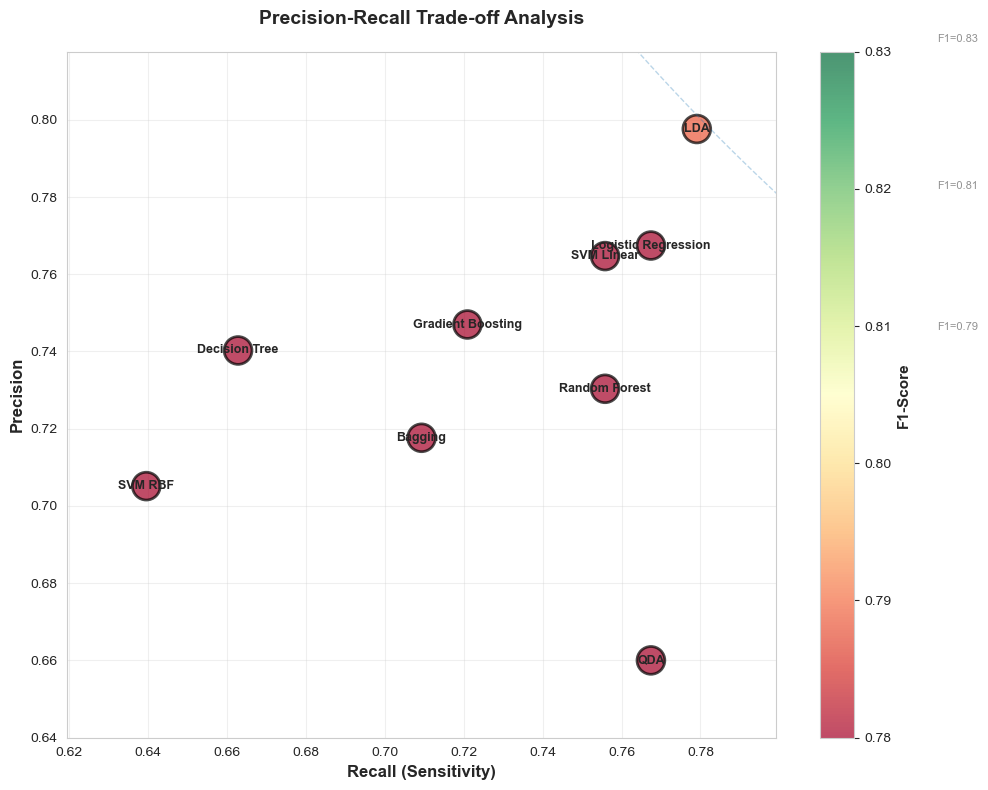

Visualization 5: Precision-Recall Trade-off - Complete


In [57]:
# Precision-Recall scatter plot
fig, ax = plt.subplots(figsize=(10, 8))

# Create scatter plot
scatter = ax.scatter(display_df['Recall'], display_df['Precision'], 
                     s=400, c=display_df['F1_Score'], cmap='RdYlGn', 
                     alpha=0.7, edgecolors='black', linewidth=2, vmin=0.78, vmax=0.83)

# Add model labels
for idx, row in display_df.iterrows():
    ax.annotate(row['Model'], 
                (row['Recall'], row['Precision']),
                fontsize=9, ha='center', va='center', fontweight='bold')

# Add F1-Score iso-curves
recall_range = np.linspace(0.75, 0.85, 100)
for f1_val in [0.79, 0.81, 0.83]:
    precision_curve = (f1_val * recall_range) / (2 * recall_range - f1_val)
    ax.plot(recall_range, precision_curve, '--', alpha=0.3, linewidth=1)
    ax.text(0.84, (f1_val * 0.84) / (2 * 0.84 - f1_val), f'F1={f1_val:.2f}', 
            fontsize=8, alpha=0.5)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('F1-Score', fontsize=11, fontweight='bold')

ax.set_xlabel('Recall (Sensitivity)', fontsize=12, fontweight='bold')
ax.set_ylabel('Precision', fontsize=12, fontweight='bold')
ax.set_title('Precision-Recall Trade-off Analysis', fontsize=14, fontweight='bold', pad=20)
ax.grid(alpha=0.3)

# Set dynamic axis limits with padding to fit all models
recall_min = display_df['Recall'].min() - 0.02
recall_max = display_df['Recall'].max() + 0.02
precision_min = display_df['Precision'].min() - 0.02
precision_max = display_df['Precision'].max() + 0.02

ax.set_xlim([recall_min, recall_max])
ax.set_ylim([precision_min, precision_max])

plt.tight_layout()
plt.show()

print("Visualization 5: Precision-Recall Trade-off - Complete")

## 9. Visualization 6: Model Category Comparison

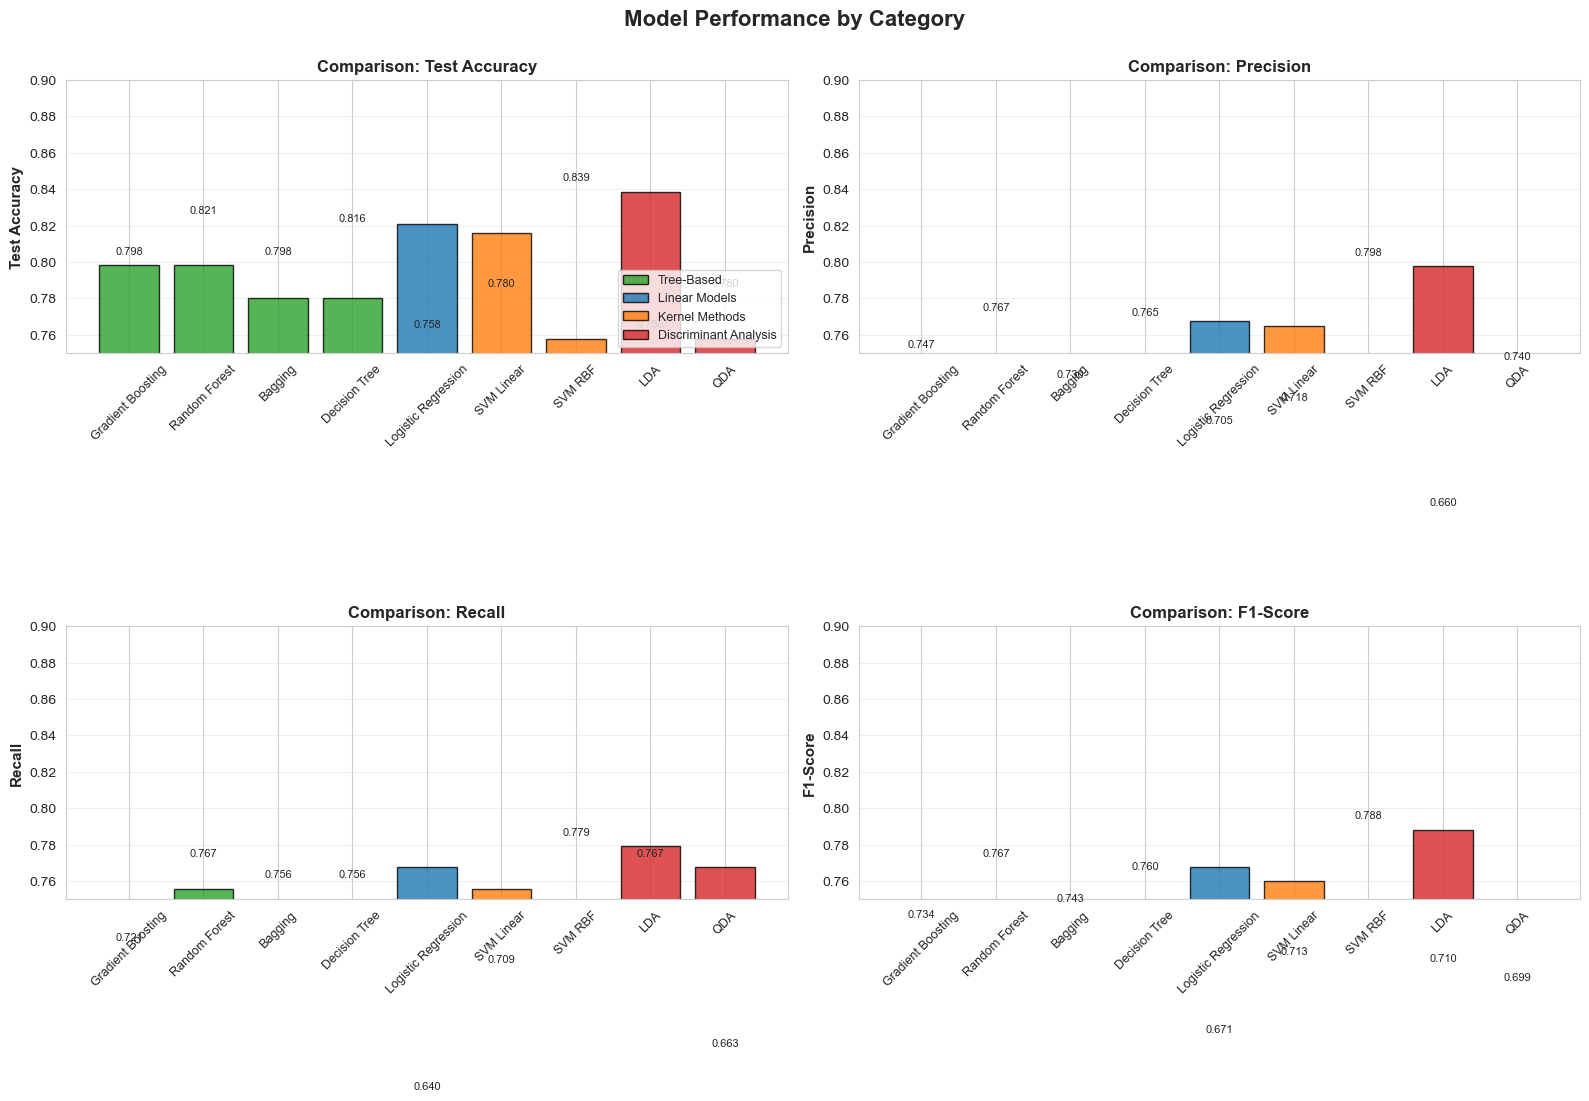

Visualization 6: Model Category Comparison - Complete


In [58]:
# Group models by category
category_mapping = {
    'Logistic Regression': 'Linear Models',
    'SVM Linear': 'Kernel Methods',
    'SVM RBF': 'Kernel Methods',
    'Decision Tree': 'Tree-Based',
    'Random Forest': 'Tree-Based',
    'Gradient Boosting': 'Tree-Based',
    'Bagging': 'Tree-Based',
    'LDA': 'Discriminant Analysis',
    'QDA': 'Discriminant Analysis'
}

display_df['Category'] = display_df['Model'].map(category_mapping)

# Create grouped bar chart
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

metrics_to_plot = ['Test_Accuracy', 'Precision', 'Recall', 'F1_Score']
metric_labels = ['Test Accuracy', 'Precision', 'Recall', 'F1-Score']
colors_category = {'Linear Models': '#1f77b4', 'Kernel Methods': '#ff7f0e', 
                   'Tree-Based': '#2ca02c', 'Discriminant Analysis': '#d62728'}

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx]
    metric_label = metric_labels[idx]
    
    # Create bar chart
    for category in display_df['Category'].unique():
        cat_data = display_df[display_df['Category'] == category]
        ax.bar(cat_data['Model'], cat_data[metric], 
               label=category, color=colors_category[category], alpha=0.8, edgecolor='black')
    
    ax.set_ylabel(metric_label, fontsize=11, fontweight='bold')
    ax.set_title(f'Comparison: {metric_label}', fontsize=12, fontweight='bold')
    ax.set_ylim([0.75, 0.90])
    ax.grid(axis='y', alpha=0.3)
    ax.tick_params(axis='x', rotation=45, labelsize=9)
    
    # Add value labels on bars
    for i, (model, value) in enumerate(zip(display_df['Model'], display_df[metric])):
        ax.text(i, value + 0.005, f'{value:.3f}', ha='center', va='bottom', fontsize=8)

# Add legend to first subplot
axes[0].legend(loc='lower right', fontsize=9)

plt.suptitle('Model Performance by Category', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()


print("Visualization 6: Model Category Comparison - Complete")

## 10. Visualization 7: Radar Chart Comparison (Top 5 Models)

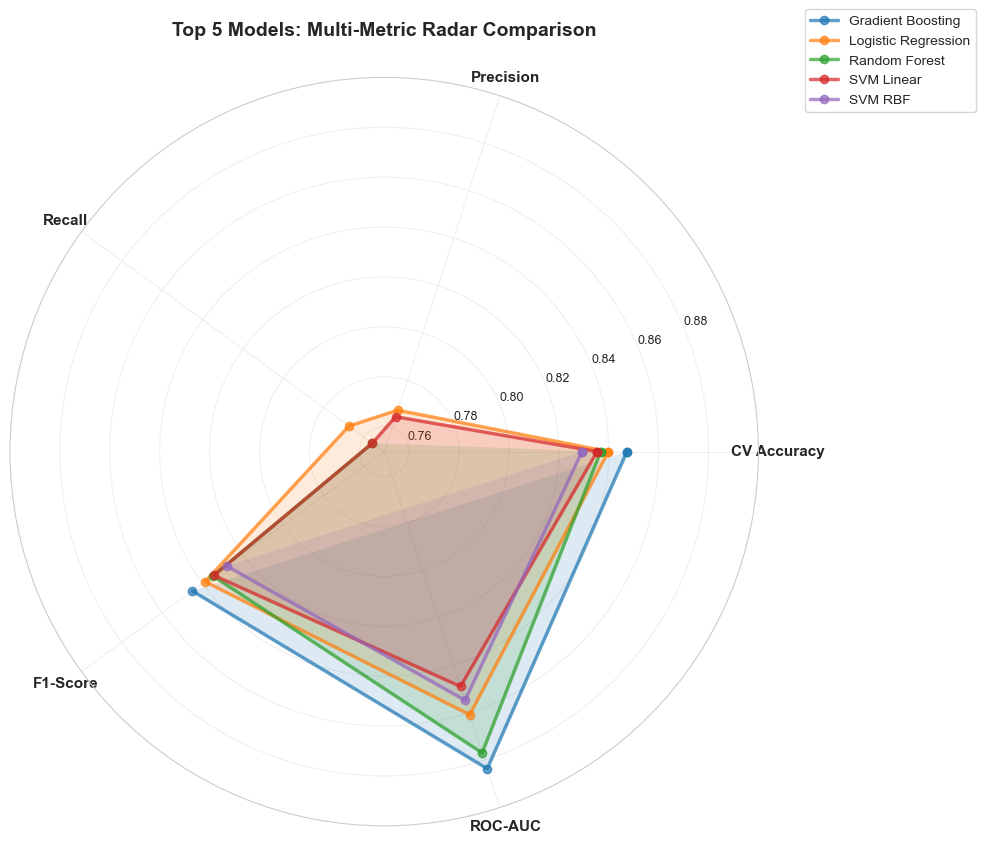

Visualization 7: Radar Chart Comparison - Complete


In [59]:
# Radar chart for top 5 models
from math import pi

# Select top 5 models
top_5 = display_df.head(5).copy()

# Metrics for radar chart (column names and display labels)
metric_cols = ['CV_Accuracy_Mean', 'Precision', 'Recall', 'CV_F1_Mean', 'CV_ROC_AUC_Mean']
categories = ['CV Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
N = len(categories)

# Create figure
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

# Calculate angles
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# Plot each model
colors_radar = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

for idx, (index, row) in enumerate(top_5.iterrows()):
    values = [row[col] for col in metric_cols]
    values += values[:1]
    
    ax.plot(angles, values, 'o-', linewidth=2.5, label=row['Model'], color=colors_radar[idx], alpha=0.7)
    ax.fill(angles, values, alpha=0.15, color=colors_radar[idx])

# Fix axis
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=11, fontweight='bold')
ax.set_ylim(0.75, 0.90)
ax.set_yticks([0.76, 0.78, 0.80, 0.82, 0.84, 0.86, 0.88])
ax.set_yticklabels(['0.76', '0.78', '0.80', '0.82', '0.84', '0.86', '0.88'], fontsize=9)
ax.grid(True, alpha=0.3)

# Add legend
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=10)

plt.title('Top 5 Models: Multi-Metric Radar Comparison', fontsize=14, fontweight='bold', pad=30)
plt.tight_layout()
plt.show()

print("Visualization 7: Radar Chart Comparison - Complete")

## 11. Statistical Summary and Insights

In [60]:
# Statistical summary with cross-validation analysis
print("\n" + "="*120)
print("STATISTICAL SUMMARY ACROSS ALL MODELS (Including Cross-Validation Analysis)")
print("="*120)

metrics_stats = display_df[['Test_Accuracy', 'CV_Accuracy_Mean', 'CV_Accuracy_Std',
                             'Precision', 'Recall', 'F1_Score', 'CV_F1_Mean', 'ROC_AUC', 'Overfit_Gap']].describe()
print(metrics_stats.T)

print("\n" + "="*120)
print("CROSS-VALIDATION CONSISTENCY ANALYSIS")
print("="*120)
print("\nModels ranked by CV stability (lower std = more consistent):")
cv_consistency = display_df[['Model', 'CV_Accuracy_Mean', 'CV_Accuracy_Std', 
                             'CV_F1_Mean', 'CV_F1_Std', 'CV_ROC_AUC_Mean', 'CV_ROC_AUC_Std']].copy()
cv_consistency['Total_Std'] = (cv_consistency['CV_Accuracy_Std'] + 
                                cv_consistency['CV_F1_Std'] + 
                                cv_consistency['CV_ROC_AUC_Std']) / 3
cv_consistency = cv_consistency.sort_values('Total_Std')
print(cv_consistency.to_string(index=False))

print("\n" + "="*120)
print("TEST ACCURACY vs CROSS-VALIDATION ACCURACY (Generalization Gap)")
print("="*120)
gap_analysis = display_df[['Model', 'Test_Accuracy', 'CV_Accuracy_Mean', 
                            'CV_Accuracy_Std', 'Overfit_Gap']].copy()
gap_analysis['Gen_Gap'] = abs(gap_analysis['Test_Accuracy'] - gap_analysis['CV_Accuracy_Mean'])
gap_analysis = gap_analysis.sort_values('Gen_Gap')
print(gap_analysis.to_string(index=False))

print("\n" + "="*120)
print("KEY INSIGHTS FROM CROSS-VALIDATION ANALYSIS")
print("="*120)

# Best performers
best_acc = display_df.loc[display_df['Test_Accuracy'].idxmax()]
best_cv_acc = display_df.loc[display_df['CV_Accuracy_Mean'].idxmax()]
best_f1 = display_df.loc[display_df['F1_Score'].idxmax()]
least_overfit = display_df.loc[display_df['Overfit_Gap'].idxmin()]
most_stable = cv_consistency.iloc[0]

print(f"\n🏆 Best Test Accuracy: {best_acc['Model']} ({best_acc['Test_Accuracy']:.4f})")
print(f"🏆 Best Cross-Validation Accuracy: {best_cv_acc['Model']} ({best_cv_acc['CV_Accuracy_Mean']:.4f} ± {best_cv_acc['CV_Accuracy_Std']:.4f})")
print(f"🏆 Best F1-Score: {best_f1['Model']} ({best_f1['F1_Score']:.4f})")
print(f"🏆 Least Overfitting: {least_overfit['Model']} (Gap: {least_overfit['Overfit_Gap']:.4f})")
print(f"🏆 Most CV Stable: {most_stable['Model']} (Avg Std: {most_stable['Total_Std']:.4f})")

# Performance range
print(f"\n📈 Test Accuracy Range: {display_df['Test_Accuracy'].min():.4f} - {display_df['Test_Accuracy'].max():.4f}")
print(f"📈 CV Accuracy Range: {display_df['CV_Accuracy_Mean'].min():.4f} - {display_df['CV_Accuracy_Mean'].max():.4f}")
print(f"📈 CV Stability (Avg Std): {cv_consistency['Total_Std'].mean():.4f}")

print("\n✅ NOTE: Cross-validation provides robust performance estimates by:")
print("   • Evaluating on multiple data splits (5-fold)")
print("   • Reducing variance from random train-test split")
print("   • Better generalization assessment")
print("   • Standard deviation shows model consistency")



STATISTICAL SUMMARY ACROSS ALL MODELS (Including Cross-Validation Analysis)
                  count      mean       std       min       25%       50%  \
Test_Accuracy       9.0  0.794220  0.027865  0.757848  0.780269  0.798206   
CV_Accuracy_Mean    9.0  0.826674  0.016735  0.793413  0.818920  0.829323   
CV_Accuracy_Std     9.0  0.027249  0.008863  0.013185  0.024077  0.028028   
Precision           9.0  0.736681  0.040066  0.660000  0.717647  0.740260   
Recall              9.0  0.728682  0.049674  0.639535  0.709302  0.755814   
F1_Score            9.0  0.731749  0.037074  0.670732  0.709677  0.733728   
CV_F1_Mean          9.0  0.825007  0.016603  0.792445  0.818126  0.828048   
ROC_AUC             9.0  0.837464  0.023968  0.799143  0.830674  0.840095   
Overfit_Gap         9.0  0.104649  0.081359  0.002752  0.023677  0.093982   

                       75%       max  
Test_Accuracy     0.816143  0.838565  
CV_Accuracy_Mean  0.836786  0.847290  
CV_Accuracy_Std   0.033556  0.03853

## 13. Export Results

In [63]:
# Save detailed results to CSV
export_df = display_df[['Model', 'Test_Accuracy', 'Train_Accuracy', 'Overfit_Gap',
                         'CV_Accuracy_Mean', 'CV_Accuracy_Std',
                         'Precision', 'Recall', 'F1_Score', 
                         'CV_F1_Mean', 'CV_F1_Std',
                         'ROC_AUC', 'CV_ROC_AUC_Mean', 'CV_ROC_AUC_Std']].copy().round(3)
export_df.to_csv('model_comparison_results_with_cv.csv', index=False)
print("✅ Detailed results with cross-validation exported to 'model_comparison_results_with_cv.csv'")

# Save hyperparameter tuning results
hp_export = results_df[['Model', 'Best_Params', 'GridSearch_CV_Score', 'Test_Accuracy']].copy()
hp_export.to_csv('hyperparameter_tuning_results.csv', index=False)
print("✅ Hyperparameter tuning results exported to 'hyperparameter_tuning_results.csv'")


✅ Detailed results with cross-validation exported to 'model_comparison_results_with_cv.csv'
✅ Hyperparameter tuning results exported to 'hyperparameter_tuning_results.csv'
